## <center>DataLab Cup 2: CNN for Object Detection</center>

The dataset contains 20 classes. The train/val data has 5012 images containing 12608 annotated objects. We have preprocessed training dataset(5012 images) and testing dataset(4953 images) for you. You can download them on Kaggle.

In [1]:
classes_name =  ["aeroplane", "bicycle", "bird", "boat", "bottle", 
                 "bus", "car", "cat", "chair", "cow", "diningtable", 
                 "dog", "horse", "motorbike", "person", "pottedplant", 
                 "sheep", "sofa", "train","tvmonitor"]

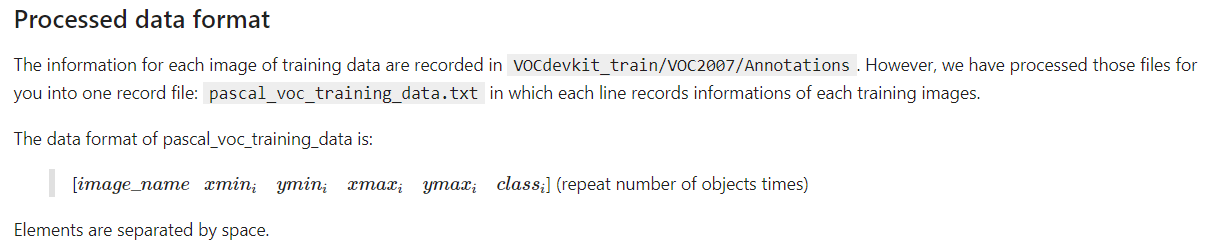

In [2]:
training_data_file = open("../datasets/pascal_voc_training_data.txt", "r")
for i, line in enumerate(training_data_file):
    if i > 5:
        break
    line = line.strip()
    print(line)

FileNotFoundError: [Errno 2] No such file or directory: '../datasets/pascal_voc_training_data.txt'

As you can see, one image may have multiple objects. Another thing to note is, the heights and widths of the images in this datset are different. Therefore, you are suggested to reshape images and ground truth bounding boxes' coordinates into same size.

In this competition, you can implement all kinds of object detection models (R-CNN, Fast-RCNN, Faster-RCNN, YOLOs, SSD,...etc.). Here we provide a simple template based on YOLO(You Only Look Once).

正如您所見，一張圖片可能包含多個物體。另一個需要注意的是，該數據集中圖片的高度和寬度是不同的。因此，建議您將圖片和實際邊界框的坐標重塑為相同的大小。

在這個競賽中，您可以實現各種物體檢測模型（R-CNN、Fast-RCNN、Faster-RCNN、YOLO、SSD等）。這裡我們提供了一個基於YOLO（You Only Look Once）的簡單模板。



In [ ]:
import tensorflow as tf
import numpy as np

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Select GPU number 1
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


- Hyperparameters

---
這些是用於實現基於YOLO的物體檢測模型的參數，以下是各個參數的解釋：

1. **共通參數（Common Params）**：
   - `IMAGE_SIZE`：圖片的大小，被調整為統一的尺寸，這裡是448。
   - `BATCH_SIZE`：訓練時每個批次的圖片數量，這裡是8。
   - `NUM_CLASSES`：類別的總數，這裡是20。
   - `MAX_OBJECTS_PER_IMAGE`：每張圖片中最大允許的物體數，這裡是20。

2. **數據集參數（Dataset Params）**：
   - `DATA_PATH`：記錄訓練數據信息的文件路徑，這裡是'./pascal_voc_training_data.txt'。
   - `IMAGE_DIR`：存放訓練圖片的目錄路徑，這裡是'./VOCdevkit_train/VOC2007/JPEGImages/'。

3. **模型參數（Model Params）**：
   - `CELL_SIZE`：網格單元的大小，YOLO將圖片分為網格，每個單元負責檢測物體，這裡是7。
   - `BOXES_PER_CELL`：每個網格單元檢測的邊界框數量，這裡是2。
   - `OBJECT_SCALE`：物體存在的比例，用於計算損失，這裡是1。
   - `NOOBJECT_SCALE`：無物體存在的比例，用於計算損失，這裡是0.5。
   - `CLASS_SCALE`：類別的比例，用於計算損失，這裡是1。
   - `COORD_SCALE`：坐標的比例，用於計算損失，這裡是5。

4. **訓練參數（Training Params）**：
   - `LEARNING_RATE`：學習率，用於調整模型權重，這裡是1e-4。
   - `EPOCHS`：訓練的迭代次數，這裡是3。

這些參數用於設定模型架構、訓練數據和訓練過程的各種參數值。當你實際訓練模型時，你可能需要調整這些參數來優化模型的性能。

In [ ]:
# common params
IMAGE_SIZE = 448
BATCH_SIZE = 8
NUM_CLASSES = 20
MAX_OBJECTS_PER_IMAGE = 20

# dataset params
DATA_PATH = '../datasets/pascal_voc_training_data.txt'
IMAGE_DIR = '../datasets/VOCdevkit_train/VOC2007/JPEGImages/'

# model params
CELL_SIZE = 7   # 所以一共會被分為64*64個grids(448/7=64)
BOXES_PER_CELL = 2 # 每一個grid可以有2個bounding box
OBJECT_SCALE = 1
NOOBJECT_SCALE = 0.5
CLASS_SCALE = 1
COORD_SCALE = 5

# training params
LEARNING_RATE = 1e-4
EPOCHS = 3

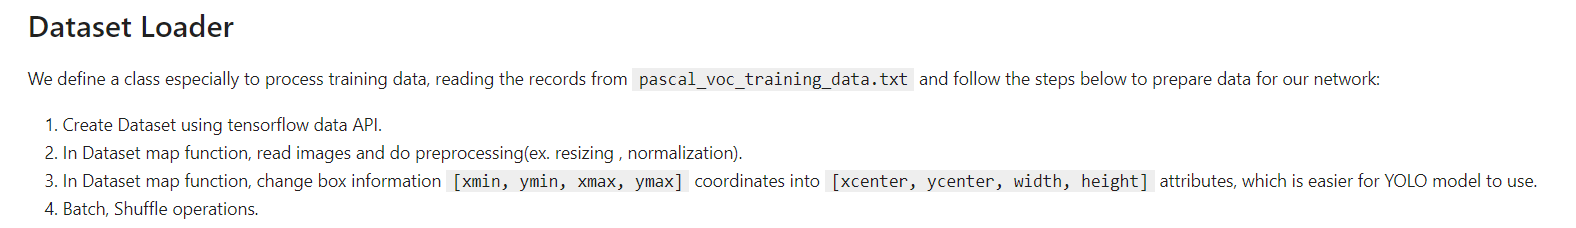

---
`tf.data.Dataset.from_tensor_slices` 是 TensorFlow 中用於創建 Dataset 對象的一種方法。讓我更詳細地解釋一下這個函數的作用：

```python
dataset = tf.data.Dataset.from_tensor_slices((tensor1, tensor2, ...))
```

這個函數的作用是基於輸入的張量（tensor）創建一個 Dataset，其中每個元素是由這些張量的相應切片組成的。這裡，`tensor1, tensor2, ...` 是輸入的張量（可以是 NumPy 數組、列表等），而 `dataset` 則是創建的 TensorFlow Dataset 對象。

考慮以下示例：

```python
import tensorflow as tf

# 假設有兩個張量，分別表示圖片和標籤
images = ["image1.jpg", "image2.jpg", "image3.jpg"]
labels = [0, 1, 0]

# 使用 from_tensor_slices 創建 Dataset
dataset = tf.data.Dataset.from_tensor_slices((images, labels))
```

這樣創建的 `dataset` 就是一個包含了 `(image, label)` 對的 Dataset。這對於將多個張量合併成一個 Dataset 是非常方便的。在你的代碼中， `self.image_names`、`np.array(self.record_list)` 和 `np.array(self.object_num_list)` 這三個張量被合併成了一個 Dataset。

最後，你可以通過對 Dataset 進行相應的操作（如 shuffle、map、batch 等）來對數據進行進一步處理，以便用於模型的訓練。

---
`dataset.prefetch(buffer_size=200)` 是 TensorFlow 中用於數據輸入流水線的一個方法。讓我們解釋一下這行程式碼的目的：

```python
dataset = dataset.prefetch(buffer_size=200)
```

- `buffer_size=200`：這是一個緩存區的大小，表示模型在訓練時可以預先加載並存儲多少個數據批次。這樣，在當前的數據批次被用於訓練的同時，模型可以同時預先加載下一個數據批次到緩存區中。

- `dataset.prefetch`：這個方法的作用是使 TensorFlow 在訓練模型的同時進行數據的異步輸入。具體來說，當模型正在進行參數的更新（訓練）時，IO（輸入/輸出）部分的數據處理可以在背景進行，這樣可以提高整個訓練過程的效率。

總的來說，`prefetch` 的使用可以幫助減少模型的等待時間，提高數據輸入效率。這在硬件資源（如 GPU）被有效利用的情況下，可以實現更流暢的訓練過程，避免模型在等待數據輸入時處於閒置狀態。

In [ ]:
class DatasetGenerator:
    """
    Load pascalVOC 2007 dataset and creates an input pipeline.
    - Reshapes images into 448 x 448
    - converts [0 1] to [-1 1]
    - shuffles the input
    - builds batches
    """

    def __init__(self):
        self.image_names = []
        self.record_list = []
        self.object_num_list = []
        # filling the record_list
        input_file = open(DATA_PATH, 'r')

        for line in input_file:
            line = line.strip()
            ss = line.split(' ')
            
            # 將每一張照片的名字都放進image_names
            self.image_names.append(ss[0])
            # 將照片的features放進record_list中
            self.record_list.append([float(num) for num in ss[1:]])
            # 計算照片中有幾的object(因為每一個object都會有5個object)
            self.object_num_list.append(min(len(self.record_list[-1])//5, 
                                            MAX_OBJECTS_PER_IMAGE))
            if len(self.record_list[-1]) < MAX_OBJECTS_PER_IMAGE*5:
                # 如果照片中的object數量小於MAX_OBJECTS_PER_IMAGE，他會將它補0，使得它數量等於MAX_OBJECTS_PER_IMAGE
                self.record_list[-1] = self.record_list[-1] +\
                [0., 0., 0., 0., 0.]*\
                (MAX_OBJECTS_PER_IMAGE-len(self.record_list[-1])//5)
                
            elif len(self.record_list[-1]) > MAX_OBJECTS_PER_IMAGE*5:
               # if there are objects more than MAX_OBJECTS_PER_IMAGE, crop the list
                self.record_list[-1] = self.record_list[-1][:MAX_OBJECTS_PER_IMAGE*5]

    def _data_preprocess(self, image_name, raw_labels, object_num):
        image_file = tf.io.read_file(IMAGE_DIR+image_name)
        image = tf.io.decode_jpeg(image_file, channels=3) # 將圖片decode成tensorflow可以用的型態

        h = tf.shape(image)[0]
        w = tf.shape(image)[1]

        width_ratio  = IMAGE_SIZE * 1.0 / tf.cast(w, tf.float32) # 計算IMAGE_SIZE除以原寬的ratio
        height_ratio = IMAGE_SIZE * 1.0 / tf.cast(h, tf.float32) # 計算IMAGE_SIZE除以原高的ratio

        image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE]) # resize圖片大小
        image = (image/255) * 2 - 1 # 將原始的像素值(在0到255之間)縮放到[0,1]的範圍內 -> 縮放到[0,2] -> 縮放到[-1,1]

        raw_labels = tf.cast(tf.reshape(raw_labels, [-1, 5]), tf.float32)

        xmin = raw_labels[:, 0]
        ymin = raw_labels[:, 1]
        xmax = raw_labels[:, 2]
        ymax = raw_labels[:, 3]
        class_num = raw_labels[:, 4]

        # 計算縮放後的center座標
        xcenter = (xmin + xmax) * 1.0 / 2.0 * width_ratio  
        ycenter = (ymin + ymax) * 1.0 / 2.0 * height_ratio

        # 計算縮放後bounding box的寬度以及高度
        box_w = (xmax - xmin) * width_ratio
        box_h = (ymax - ymin) * height_ratio

        labels = tf.stack([xcenter, ycenter, box_w, box_h, class_num], axis=1)

        return image, labels, tf.cast(object_num, tf.int32)

    def generate(self):
        dataset = tf.data.Dataset.from_tensor_slices((self.image_names, 
                                                      np.array(self.record_list), 
                                                      np.array(self.object_num_list)))
        dataset = dataset.shuffle(100000)
        dataset = dataset.map(self._data_preprocess, 
                              num_parallel_calls = tf.data.experimental.AUTOTUNE) # 自動選擇並行處理的數量，以最大程度地加速數據輸入的處理
        dataset = dataset.batch(BATCH_SIZE)
        dataset = dataset.prefetch(buffer_size=200)

        return dataset

Now we can simply new a `DatasetGenerator` which can provide batches of training data for our model.

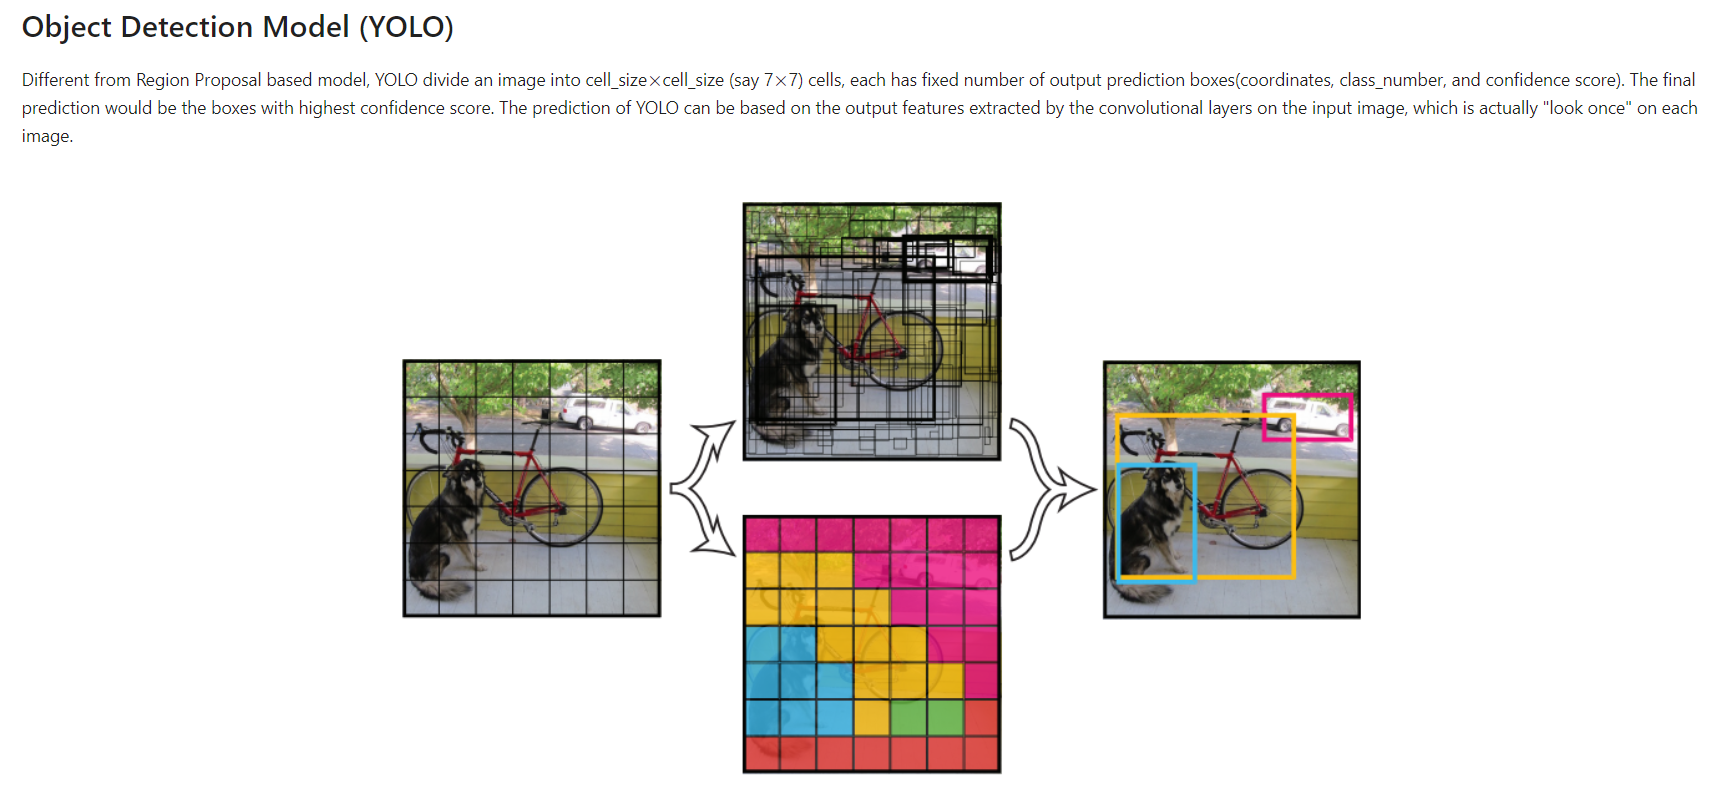

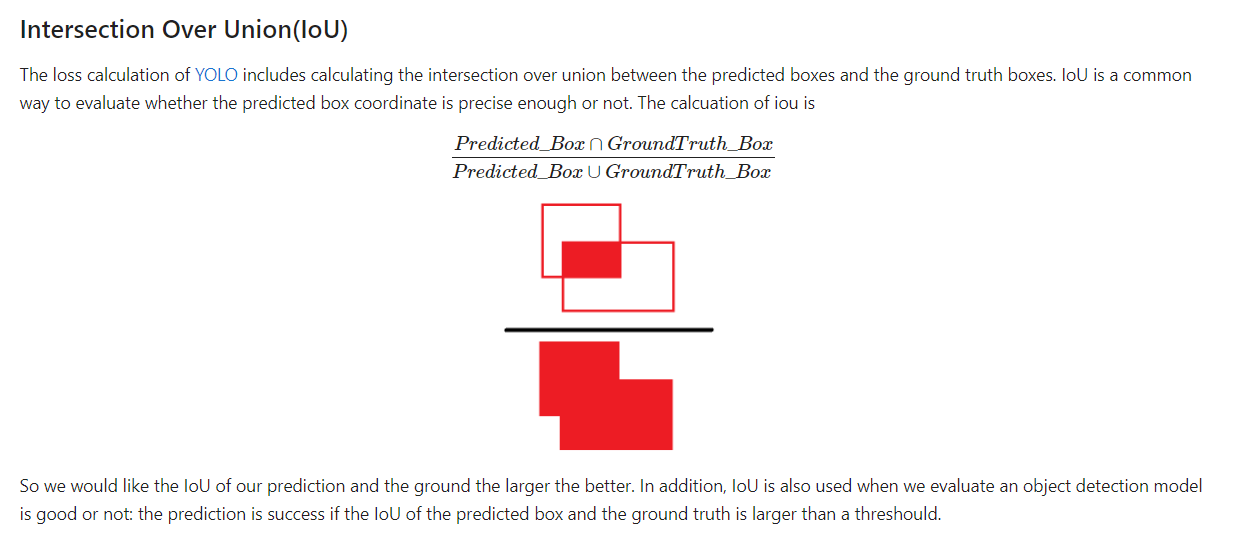

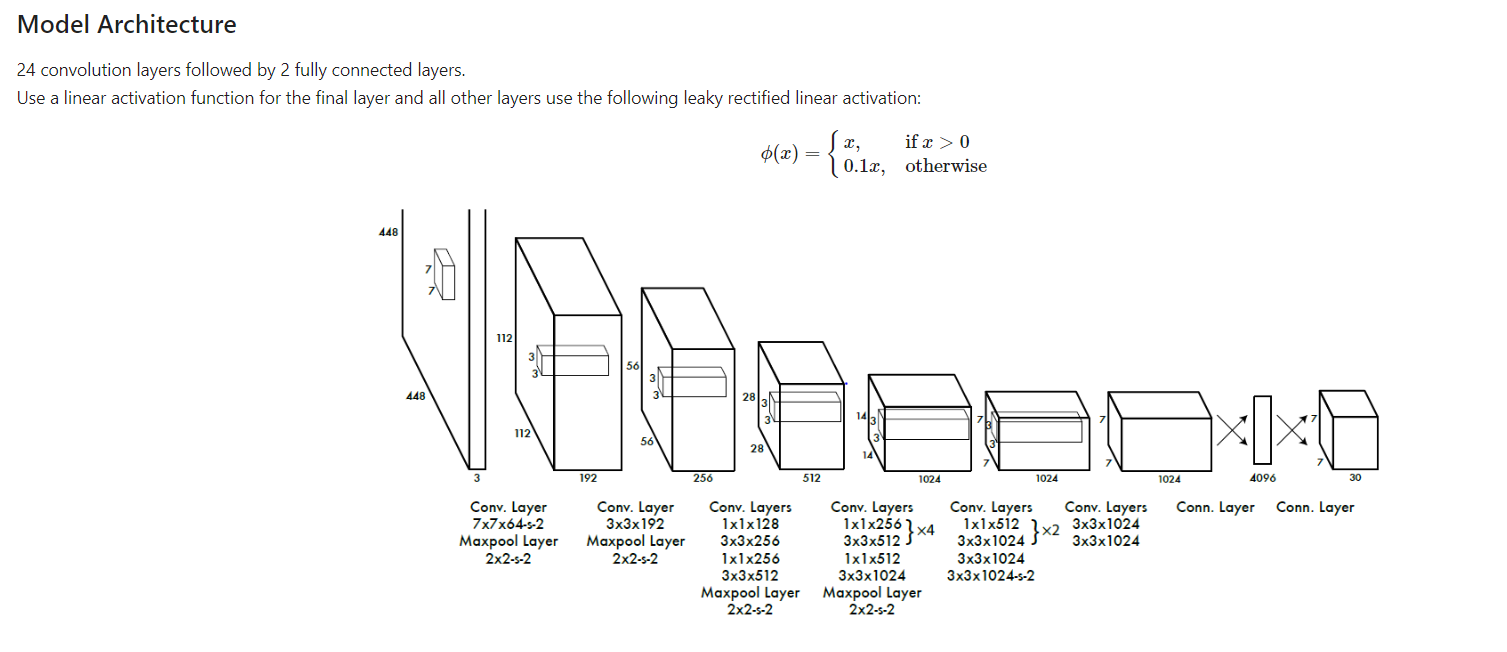

### 以前面幾層為例

#### **1. conv2d_24**
* ifmap: $1*448*448*3$
* filter: $7*7*3*64$
* stride: 2
* padding: 3

讓我們使用給定的公式來檢查這個情況：

$ N = \frac{{W - F + 2P}}{{S}} + 1 $

將這些值代入公式：

$ N = 224.5 $ -> 向下取整 -> $224$


-> ofmap: $1*224*224*64$

#### **2. max_pooling2d_4 **

* ifmap: $1*224*224*64$
* kernel: $2*2$
* stride: 2

-> ofmap: $1*112*112*64$


#### **3. conv2d_25**
* ifmap: $1*112*112*64$
* filter: $3*3*64*192$
* stride: 1
* padding: 1

讓我們使用給定的公式來檢查這個情況：

$ N = \frac{{W - F + 2P}}{{S}} + 1 $

將這些值代入公式：

$ N = 112 $


-> ofmap: $1*112*112*192$

#### **4. max_pooling2d_5  **

* ifmap: $1*112*112*192$
* kernel: $2*2$
* stride: 2

-> ofmap: $1*56*56*64$

### Model

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

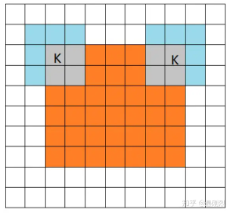

In [ ]:
def conv_leaky_relu(inputs, filters, size, stride):
    # 計算尺寸不被整除時，卷積向下取整，池化向上取整
    x = layers.Conv2D(filters, size, stride, padding="same", # 當filter的中心(K)與image的邊角重合時，開始做卷積運算
                      kernel_initializer=tf.keras.initializers.TruncatedNormal())(inputs)
    x = layers.LeakyReLU(0.1)(x)

    return x

In [ ]:
img_inputs = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
x = conv_leaky_relu(img_inputs, 64, 7, 2)
x = layers.MaxPool2D()(x)
x = conv_leaky_relu(x, 192, 3, 1)
x = layers.MaxPool2D()(x)
x = conv_leaky_relu(x, 128, 1, 1)
x = conv_leaky_relu(x, 256, 3, 1)
x = conv_leaky_relu(x, 256, 1, 1)
x = conv_leaky_relu(x, 512, 3, 1)
x = layers.MaxPool2D()(x)
x = conv_leaky_relu(x, 256, 1, 1)
x = conv_leaky_relu(x, 512, 3, 1)
x = conv_leaky_relu(x, 256, 1, 1)
x = conv_leaky_relu(x, 512, 3, 1)
x = conv_leaky_relu(x, 256, 1, 1)
x = conv_leaky_relu(x, 512, 3, 1)
x = conv_leaky_relu(x, 256, 1, 1)
x = conv_leaky_relu(x, 512, 3, 1)
x = conv_leaky_relu(x, 512, 1, 1)
x = conv_leaky_relu(x, 1024, 3, 1)
x = layers.MaxPool2D()(x)
x = conv_leaky_relu(x, 512, 1, 1)
x = conv_leaky_relu(x, 1024, 3, 1)
x = conv_leaky_relu(x, 512, 1, 1)
x = conv_leaky_relu(x, 1024, 3, 1)
x = conv_leaky_relu(x, 1024, 3, 1)
x = conv_leaky_relu(x, 1024, 3, 2)
x = conv_leaky_relu(x, 1024, 3, 1)
x = conv_leaky_relu(x, 1024, 3, 1)
x = layers.Flatten()(x)
x = layers.Dense(4096, 
                 kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x)
x = layers.LeakyReLU(0.1)(x)
outputs = layers.Dense(1470, 
                       kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x)

YOLO = keras.Model(inputs=img_inputs, outputs=outputs, name="YOLO")

In [ ]:
YOLO.summary()

Model: "YOLO"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 448, 448, 3)]     0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 224, 224, 64)      9472      
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 224, 224, 64)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 112, 112, 192)     110784    
_________________________________________________________________
leaky_re_lu_26 (LeakyReLU)   (None, 112, 112, 192)     0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 56, 56, 192)       0      

### Define loss

In [ ]:
# base boxes (for loss calculation)
base_boxes = np.zeros([CELL_SIZE, CELL_SIZE, 4])

# initializtion for each cell
for y in range(CELL_SIZE):
    for x in range(CELL_SIZE):
        base_boxes[y, x, :] = [IMAGE_SIZE / CELL_SIZE * x, 
                               IMAGE_SIZE / CELL_SIZE * y, 0, 0]

base_boxes = np.resize(base_boxes, [CELL_SIZE, CELL_SIZE, 1, 4])
base_boxes = np.tile(base_boxes, [1, 1, BOXES_PER_CELL, 1])

In [ ]:
def yolo_loss(predicts, labels, objects_num):
    """
    Add Loss to all the trainable variables
    Args:
        predicts: 4-D tensor [batch_size, cell_size, cell_size, num_classes + 5 * boxes_per_cell]
        ===> (num_classes, boxes_per_cell, 4 * boxes_per_cell)
        labels  : 3-D tensor of [batch_size, max_objects, 5]
        objects_num: 1-D tensor [batch_size]
    """

    loss = 0.
    
    #you can parallel the code with tf.map_fn or tf.vectorized_map (big performance gain!)
    for i in tf.range(BATCH_SIZE):
        predict = predicts[i, :, :, :]
        label = labels[i, :, :]
        object_num = objects_num[i]

        for j in tf.range(object_num):
            results = losses_calculation(predict, label[j:j+1, :])
            loss = loss + results

    return loss/BATCH_SIZE

In [ ]:
def iou(boxes1, boxes2):
    """calculate ious
    Args:
      boxes1: 4-D tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 4]  ====> (x_center, y_center, w, h)
      boxes2: 1-D tensor [4] ===> (x_center, y_center, w, h)

    Return:
      iou: 3-D tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
      ====> iou score for each cell
    """

    #boxes1 : [4(xmin, ymin, xmax, ymax), cell_size, cell_size, boxes_per_cell]
    boxes1 = tf.stack([boxes1[:, :, :, 0] - boxes1[:, :, :, 2] / 2, boxes1[:, :, :, 1] - boxes1[:, :, :, 3] / 2,
                      boxes1[:, :, :, 0] + boxes1[:, :, :, 2] / 2, boxes1[:, :, :, 1] + boxes1[:, :, :, 3] / 2])

    #boxes1 : [cell_size, cell_size, boxes_per_cell, 4(xmin, ymin, xmax, ymax)]
    boxes1 = tf.transpose(boxes1, [1, 2, 3, 0])

    boxes2 =  tf.stack([boxes2[0] - boxes2[2] / 2, boxes2[1] - boxes2[3] / 2,
                      boxes2[0] + boxes2[2] / 2, boxes2[1] + boxes2[3] / 2])

    #calculate the left up point of boxes' overlap area
    lu = tf.maximum(boxes1[:, :, :, 0:2], boxes2[0:2])
    #calculate the right down point of boxes overlap area
    rd = tf.minimum(boxes1[:, :, :, 2:], boxes2[2:])

    #intersection
    intersection = rd - lu 

    #the size of the intersection area
    inter_square = intersection[:, :, :, 0] * intersection[:, :, :, 1]

    mask = tf.cast(intersection[:, :, :, 0] > 0, tf.float32) * tf.cast(intersection[:, :, :, 1] > 0, tf.float32)

    #if intersection is negative, then the boxes don't overlap
    inter_square = mask * inter_square

    #calculate the boxs1 square and boxs2 square
    square1 = (boxes1[:, :, :, 2] - boxes1[:, :, :, 0]) * (boxes1[:, :, :, 3] - boxes1[:, :, :, 1])
    square2 = (boxes2[2] - boxes2[0]) * (boxes2[3] - boxes2[1])

    return inter_square/(square1 + square2 - inter_square + 1e-6)

def losses_calculation(predict, label):
    """
    calculate loss
    Args:
      predict: 3-D tensor [cell_size, cell_size, num_classes + 5 * boxes_per_cell]
      label : [1, 5]  (x_center, y_center, w, h, class)
    """
    label = tf.reshape(label, [-1])

    #Step A. calculate objects tensor [CELL_SIZE, CELL_SIZE]
    #turn pixel position into cell position (corner)
    min_x = (label[0] - label[2] / 2) / (IMAGE_SIZE / CELL_SIZE)
    max_x = (label[0] + label[2] / 2) / (IMAGE_SIZE / CELL_SIZE)

    min_y = (label[1] - label[3] / 2) / (IMAGE_SIZE / CELL_SIZE)
    max_y = (label[1] + label[3] / 2) / (IMAGE_SIZE / CELL_SIZE)

    min_x = tf.floor(min_x)
    min_y = tf.floor(min_y)

    max_x = tf.minimum(tf.math.ceil(max_x), CELL_SIZE)
    max_y = tf.minimum(tf.math.ceil(max_y), CELL_SIZE)
    
    #calculate mask of object with cells
    onset = tf.cast(tf.stack([max_y - min_y, max_x - min_x]), dtype=tf.int32)
    object_mask = tf.ones(onset, tf.float32)

    offset = tf.cast(tf.stack([min_y, CELL_SIZE - max_y, min_x, CELL_SIZE - max_x]), tf.int32)
    offset = tf.reshape(offset, (2, 2))
    object_mask = tf.pad(object_mask, offset, "CONSTANT")

    #Step B. calculate the coordination of object center and the corresponding mask
    #turn pixel position into cell position (center)
    center_x = label[0] / (IMAGE_SIZE / CELL_SIZE)
    center_x = tf.floor(center_x)

    center_y = label[1] / (IMAGE_SIZE / CELL_SIZE)
    center_y = tf.floor(center_y)

    response = tf.ones([1, 1], tf.float32)

    #calculate the coordination of object center with cells
    objects_center_coord = tf.cast(tf.stack([center_y, CELL_SIZE - center_y - 1, 
                             center_x, CELL_SIZE - center_x - 1]), 
                             tf.int32)
    objects_center_coord = tf.reshape(objects_center_coord, (2, 2))

    #make mask
    response = tf.pad(response, objects_center_coord, "CONSTANT")

    #Step C. calculate iou_predict_truth [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    predict_boxes = predict[:, :, NUM_CLASSES + BOXES_PER_CELL:]

    predict_boxes = tf.reshape(predict_boxes, [CELL_SIZE, 
                                               CELL_SIZE, 
                                               BOXES_PER_CELL, 4])
    #cell position to pixel position
    predict_boxes = predict_boxes * [IMAGE_SIZE / CELL_SIZE, 
                                     IMAGE_SIZE / CELL_SIZE, 
                                     IMAGE_SIZE, IMAGE_SIZE]

    #if there's no predict_box in that cell, then the base_boxes will be calcuated with label and got iou equals 0
    predict_boxes = base_boxes + predict_boxes

    iou_predict_truth = iou(predict_boxes, label[0:4])

    #calculate C tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    C = iou_predict_truth * tf.reshape(response, [CELL_SIZE, CELL_SIZE, 1])

    #calculate I tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    I = iou_predict_truth * tf.reshape(response, [CELL_SIZE, CELL_SIZE, 1])

    max_I = tf.reduce_max(I, 2, keepdims=True)

    #replace large iou scores with response (object center) value
    I = tf.cast((I >= max_I), tf.float32) * tf.reshape(response, (CELL_SIZE, CELL_SIZE, 1))

    #calculate no_I tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    no_I = tf.ones_like(I, dtype=tf.float32) - I

    p_C = predict[:, :, NUM_CLASSES:NUM_CLASSES + BOXES_PER_CELL]

    #calculate truth x, y, sqrt_w, sqrt_h 0-D
    x = label[0]
    y = label[1]

    sqrt_w = tf.sqrt(tf.abs(label[2]))
    sqrt_h = tf.sqrt(tf.abs(label[3]))

    #calculate predict p_x, p_y, p_sqrt_w, p_sqrt_h 3-D [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    p_x = predict_boxes[:, :, :, 0]
    p_y = predict_boxes[:, :, :, 1]

    p_sqrt_w = tf.sqrt(tf.minimum(IMAGE_SIZE * 1.0, tf.maximum(0.0, predict_boxes[:, :, :, 2])))
    p_sqrt_h = tf.sqrt(tf.minimum(IMAGE_SIZE * 1.0, tf.maximum(0.0, predict_boxes[:, :, :, 3])))

    #calculate ground truth p 1-D tensor [NUM_CLASSES]
    P = tf.one_hot(tf.cast(label[4], tf.int32), NUM_CLASSES, dtype=tf.float32)

    #calculate predicted p_P 3-D tensor [CELL_SIZE, CELL_SIZE, NUM_CLASSES]
    p_P = predict[:, :, 0:NUM_CLASSES]

    #class_loss
    class_loss = tf.nn.l2_loss(tf.reshape(object_mask, (CELL_SIZE, CELL_SIZE, 1)) * (p_P - P)) * CLASS_SCALE

    #object_loss
    object_loss = tf.nn.l2_loss(I * (p_C - C)) * OBJECT_SCALE

    #noobject_loss
    noobject_loss = tf.nn.l2_loss(no_I * (p_C)) * NOOBJECT_SCALE

    #coord_loss
    coord_loss = (tf.nn.l2_loss(I * (p_x - x)/(IMAGE_SIZE/CELL_SIZE)) +
                  tf.nn.l2_loss(I * (p_y - y)/(IMAGE_SIZE/CELL_SIZE)) +
                  tf.nn.l2_loss(I * (p_sqrt_w - sqrt_w))/IMAGE_SIZE +
                  tf.nn.l2_loss(I * (p_sqrt_h - sqrt_h))/IMAGE_SIZE) * COORD_SCALE

    return class_loss + object_loss + noobject_loss + coord_loss

### Start Training

Now we can start training our YOLO model:

In [ ]:
dataset = DatasetGenerator().generate()

In [ ]:
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
train_loss_metric = tf.keras.metrics.Mean(name='loss')

In [ ]:
ckpt = tf.train.Checkpoint(epoch=tf.Variable(0), net=YOLO)

manager = tf.train.CheckpointManager(ckpt, './ckpts/YOLO', max_to_keep=3,
                                     checkpoint_name='yolo')

In [ ]:
@tf.function
def train_step(image, labels, objects_num):
    with tf.GradientTape() as tape:
        outputs = YOLO(image)
        class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
        conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
        class_probs = tf.reshape(outputs[:, 0:class_end], (-1, 7, 7, 20))
        confs = tf.reshape(outputs[:, class_end:conf_end], (-1, 7, 7, 2))
        boxes = tf.reshape(outputs[:, conf_end:], (-1, 7, 7, 2*4))
        predicts = tf.concat([class_probs, confs, boxes], 3)

        loss = yolo_loss(predicts, labels, objects_num)
        train_loss_metric(loss)

    grads = tape.gradient(loss, YOLO.trainable_weights)
    optimizer.apply_gradients(zip(grads, YOLO.trainable_weights))

In [ ]:
from datetime import datetime

In [ ]:
print("{}, start training.".format(datetime.now()))
for i in range(EPOCHS):
    train_loss_metric.reset_states()
    ckpt.epoch.assign_add(1)

    for idx, (image, labels, objects_num) in enumerate(dataset):
        train_step(image, labels, objects_num)

    print("{}, Epoch {}: loss {:.2f}".format(datetime.now(), i+1, train_loss_metric.result()))

    save_path = manager.save()
    print("Saved checkpoint for epoch {}: {}".format(int(ckpt.epoch), save_path))    

2023-11-15 16:09:27.664035, start training.


: 